# Task Description
1. Проанализировать данные в файле
2. Построить гипотезы
3. Обучить логистическую регрессию
4. Снять метрики качества
5. Результат выполненного тестового задания: ссылка на открытый репозиторий в Git

В файле поле Marker - целевая функция

In [ ]:
# !pip install pyxlsb

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

DATA_PATH = "/content/drive/MyDrive/alpha_test_task/Training.xlsb"
RANDOM_STATE = 42

In [ ]:
def inspect_table(data):
    types = data.dtypes
    total = data.count()
    nan_report = data.isna().sum(0)
    unique_report = data.nunique()

    report = pd.concat({
                'types': types,
                'total': total,
                'nan': nan_report,
                'n_unique': unique_report}, axis=1)  
    
    return report

def print_numeric_stats(data, col_name):
    print(f'Count: {data[col_name].count()}')
    print(f'Distinct: {data[col_name].nunique()}')
    print(f'Distinct(%): {data[col_name].nunique() / data[col_name].count() * 100}%')
    print(f'Minimum: {data[col_name].min()}')
    print(f'Maximum: {data[col_name].max()}')
    print(f'Mean: {data[col_name].mean()}')
    print(f'Median: {data[col_name].median()}')
    Q1, Q2 = data[col_name].describe()['25%'], data[col_name].describe()['75%']
    IQR = Q2 - Q1
    print(f'Interquartile range: {IQR}')
    print()
    print(f'Левая граница выброса: {(Q1 - 1.5 * IQR) if Q1 - 1.5 * IQR >= data[col_name].min() else data[col_name].min()}')
    print(f'Правая граница выброса: {(Q2 + 1.5 * IQR) if Q2 + 1.5 * IQR <= data[col_name].max() else data[col_name].max()}')
    print(f'Кол-во выбросов: {data[((data[col_name] < (Q1 - 1.5 * IQR)) | (data[col_name] > (Q2 + 1.5 * IQR)))].shape[0]}')
    print(f'Кол-во выбросов(%): {((data[((data[col_name] < (Q1 - 1.5 * IQR)) | (data[col_name] > (Q2 + 1.5 * IQR)))].shape[0]) / data[col_name].count()) * 100}')
    print()

    print('после логарифмирования:')
    df = data.copy()
    df[col_name] = np.log(df[col_name] + 1)
    Q1, Q2 = df[col_name].describe()['25%'], df[col_name].describe()['75%']
    IQR = Q2 - Q1
    print(f'Левая граница выброса: {(Q1 - 1.5 * IQR) if Q1 - 1.5 * IQR >= df[col_name].min() else df[col_name].min()}')
    print(f'Правая граница выброса: {(Q2 + 1.5 * IQR) if Q2 + 1.5 * IQR <= df[col_name].max() else df[col_name].max()}')
    print(f'Кол-во выбросов: {df[((df[col_name] < (Q1 - 1.5 * IQR)) | (df[col_name] > (Q2 + 1.5 * IQR)))].shape[0]}')
    print(f'Кол-во выбросов(%): {((df[((df[col_name] < (Q1 - 1.5 * IQR)) | (df[col_name] > (Q2 + 1.5 * IQR)))].shape[0]) / df[col_name].count()) * 100}')


def print_categorical_stats(data, col_name):
    print(f"Column: {col_name}")
    display(pd.DataFrame({
      'count': data[col_name].value_counts(),
      'frequency(%)': (data[col_name].value_counts() / data.shape[0]) * 100
    }))
    return

def plot_univariate_numeric(data, col_name, figsize=(20, 10)):
    df = data.copy()
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
    sns.histplot(x=col_name, data=df, ax=axes[0], kde=True)
    sns.boxplot(y=col_name, data=df, ax=axes[1])

    # log column
    df[f"{col_name}_log"] = np.log(df[col_name] + 1)
    sns.histplot(x=f"{col_name}_log", data=df, ax=axes[2], kde=True)
    sns.boxplot(y=f"{col_name}_log", data=df, ax=axes[3])

def plot_univariate_categoric(data, col_name, figsize=(20, 10)):
    total = data[col_name].count()
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=col_name, hue=col_name, data=data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                    ha='center', # центрирование
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points', # точка смещения относительно координаты
                    fontsize=14)
    plt.show()

def plot_bivariate_numeric(data, col_name, figsize=(20, 10)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    sns.kdeplot(data=data, x=col_name, hue='MARKER', common_norm=False, ax=axes[0])
    sns.boxplot(data=data, x='MARKER', y=col_name, ax=axes[1])

# Data Quality Assessment and Profiling
In this section we will get familiar with the data, try to understand what the data represents and what's missing:

In [ ]:
data = pd.read_excel(DATA_PATH)
data.head()

,ID,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,61.250000,Minsk region,48,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,48.583333,Brest region,48,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [ ]:
data.shape

(89734, 26)

**Number of observations:** 89734  
**Number of variables:** 26 (out of which one (**MARKER**) is target variable)  

We can already see that we have a column **ID**. We can check it for duplicates and if there are no duplicates, we can safely set this column as the index of the dataframe and exclude it from the subsequent exploration:

In [ ]:
data['ID'].duplicated().sum()

0

All records are unique, let's set this column as index:

In [ ]:
data.set_index('ID', inplace=True)

### Overall Statistics

In [ ]:
report = inspect_table(data)
report

,types,total,nan,n_unique
A,float64,89734,0,46408
B,float64,89734,0,56381
C,float64,89734,0,11051
D,float64,89734,0,14941
E,float64,89734,0,49962
F,float64,89734,0,59471
G,int64,89734,0,11
H,float64,89734,0,13
I,object,89734,0,2
J,float64,89734,0,528


Check for duplicates:

In [ ]:
data.duplicated().sum()

0

Results:
- no missing values
- no duplicated records
- variables **G**, **H** and **MARKER** (target) reported as numeric, but take small number of values. Let's assess their values, percent of unique values and decide whether we can consider them categorical:

In [ ]:
for col_name in ['G', 'H', 'MARKER']:
  print_categorical_stats(data, col_name)

Column: G


,count,frequency(%)
5,24914,27.764281
13,22011,24.529164
3,14842,16.539996
10,12424,13.845365
2,5287,5.891858
20,3722,4.147815
4,3557,3.963938
6,1518,1.691666
11,804,0.895981
9,506,0.563889


Column: H


,count,frequency(%)
0.000,63346,70.593086
1.990,14108,15.722023
2.490,5784,6.445717
0.010,5115,5.700181
3.500,298,0.332093
2.500,277,0.308690
2.990,255,0.284173
1.235,231,0.257428
1.100,117,0.130385
1.170,109,0.121470


Column: MARKER


,count,frequency(%)
0,89392,99.618874
1,342,0.381126


- **MARKER** (target) is categorical column and has huge imbalance, we need to take this into consideration when choosing metrics and evaluating them
- I'm not sure how to interpret values of **G**, let's leave it as it is for now and keep it in mind in further analysis
-same goes for **H**. It takes float values, but 70% of values take 0.0 value (could it indicate missing value or some category?) and only one record in dataset takes value 3.0 (possible outlier?)

In [ ]:
data[['MARKER']] = data[['MARKER']].astype(object)

### Numeric variables

Select numeric columns:

In [ ]:
num_cols = data.select_dtypes(include='number').columns.tolist()
print(num_cols)
print(f"Number of numeric columns: {len(num_cols)}")

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L']
Number of numeric columns: 10


In [ ]:
data.describe()

,A,B,C,D,E,F,G,H,J,L
count,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000
mean,0.167863,0.113511,85.801266,548.507954,1.011455,0.683640,7.854358,0.510274,41.140778,103.719092
std,0.153851,0.105340,105.366771,448.686233,0.910583,0.622047,4.754588,0.928146,11.129976,100.458022
min,0.000002,0.000001,0.000000,49.980000,0.000016,0.000012,2.000000,0.000000,21.000000,0.000000
25%,0.065843,0.042922,20.570000,227.030000,0.405983,0.263775,4.000000,0.000000,32.083333,29.000000
50%,0.119133,0.079733,50.020000,408.735000,0.749403,0.499387,5.000000,0.000000,40.000000,69.000000
75%,0.220000,0.146990,108.930000,746.710000,1.333367,0.899260,13.000000,0.010000,50.000000,144.000000
max,7.067250,0.874025,2682.420000,4999.000000,35.337000,10.352991,24.000000,3.500000,64.916667,540.000000


- for most of the columns mean and median values significantly differ from max value, we should check them for possible outliers
- column **J** actually looks like an age (если предположить, что решается задача кредитного скоринга/предсказания дефолта клиента, то можно воспользоваться информацией с сайта Альфа-Банка, где указано, что на момент обращения возраст – от 21 года, а к моменту полного погашения – не более 64 лет, что согласуется с минимальным и максимальным значением данной колонки)

### Categorical columns

Select categorical columns:

In [ ]:
cat_cols = data.select_dtypes(include='object').columns.tolist()
print(cat_cols)
print(f"Number of categorical columns: {len(cat_cols)}")

['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'MARKER']
Number of categorical columns: 15


In [ ]:
data.describe(include=object)

,I,K,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
count,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734,89734
unique,2,7,5,4,4,5,3,2,5,2,2,3,2,2,2
top,Woman,Minsk region,NE employee,Secondary education (plus special education),Married,0 Zero,property,No,Works,Yes,Yes,No,No,No,0
freq,48996,15274,72475,58363,63273,44229,81457,74357,47413,75356,76546,78462,51577,55095,89392


- we have already noticed a very strong imbalance in the target variable
- we see that there is a rather strong imbalance in the variables **M**, **Q**, **R**, **T**, **U**, **V**
- some redundant information in column **P** values (0 Zero)
- we will take a closer look at the unique values and their frequencies in the next part

### Key points

- no missing values detected
- no duplicates detected
- **MARKER** (target) is categorical (takes two values - 0 and 1) and has huge imbalance (99.6% samples of class 0). I assume that we are dealing with the credit scoring task, it also couls be customer churn prediction, but I am more inclined to the first option because of the range of values of column **J**, which apparently represents age

# Exploration

## 1. Exploring each individual variable

### 1.1 Numeric variables

In [ ]:
num_cols

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L']

**A:**

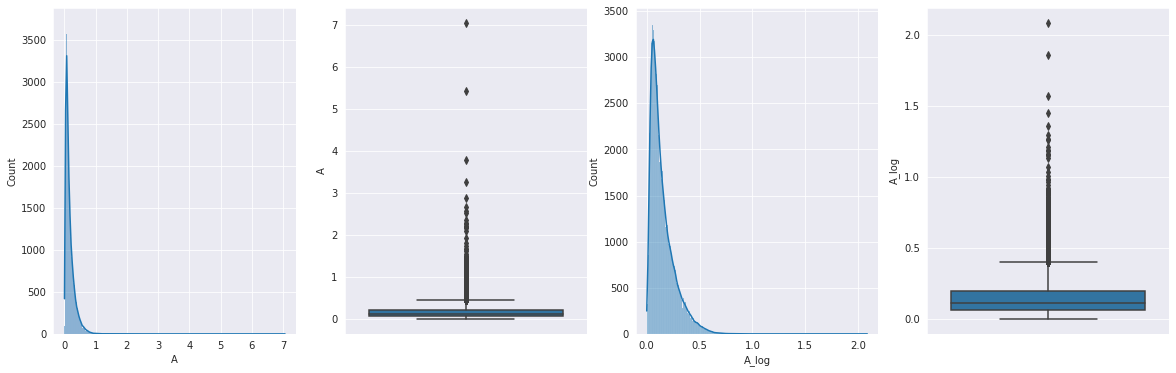

In [ ]:
plot_univariate_numeric(data, 'A', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'A')

Count: 89734
Distinct: 46408
Distinct(%): 51.71729779124969%
Minimum: 1.6280000000000001e-06
Maximum: 7.06725
Mean: 0.16786345693268295
Median: 0.11913333333333334
Interquartile range: 0.15415714285714285

Левая граница выброса: 1.6280000000000001e-06
Правая граница выброса: 0.4512357142857143
Кол-во выбросов: 5046
Кол-во выбросов(%): 5.623286602625538

после логарифмирования:
Левая граница выброса: 1.627998674729687e-06
Правая граница выброса: 0.40147829489017595
Кол-во выбросов: 3804
Кол-во выбросов(%): 4.239195845498919


In [ ]:
data['A'] = np.log(data['A'] + 1)

- распределение скошено вправо - взяли логарифм
- выбросов не очень много, но достаточно, пока оставим их и построим модель, а потом вернемся к этому при необходимости

**B:**

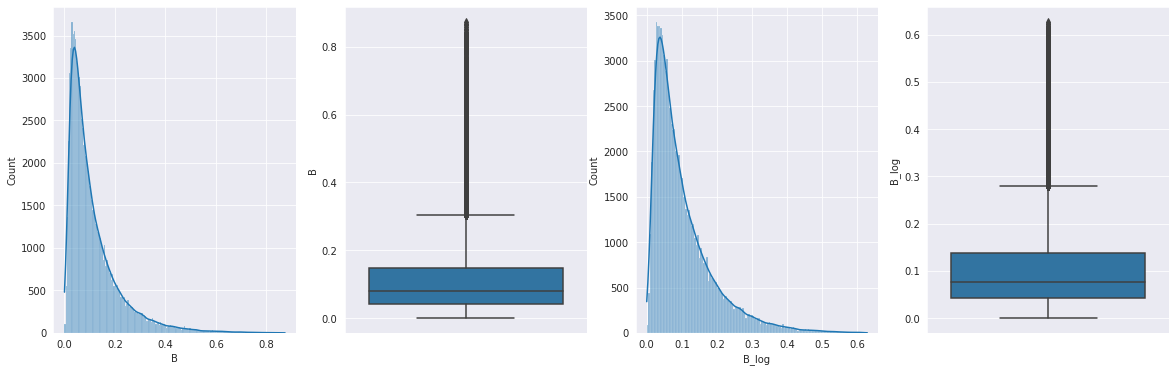

In [ ]:
plot_univariate_numeric(data, 'B', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'B')

Count: 89734
Distinct: 56381
Distinct(%): 62.831256825729376%
Minimum: 1.2059259259259261e-06
Maximum: 0.874025
Mean: 0.11351094285393405
Median: 0.07973333333333334
Interquartile range: 0.10406784945086293

Левая граница выброса: 1.2059259259259261e-06
Правая граница выброса: 0.303091642597347
Кол-во выбросов: 5485
Кол-во выбросов(%): 6.112510308244367

после логарифмирования:
Левая граница выброса: 1.205925198878572e-06
Правая граница выброса: 0.27981290178840934
Кол-во выбросов: 4572
Кол-во выбросов(%): 5.09505872913277


In [ ]:
data['B'] = np.log(data['B'] + 1)

- распределение скошено вправо - взяли логарифм
- выбросов не очень много, но достаточно, пока оставим их и построим модель, а потом вернемся к этому при необходимости

**C:**

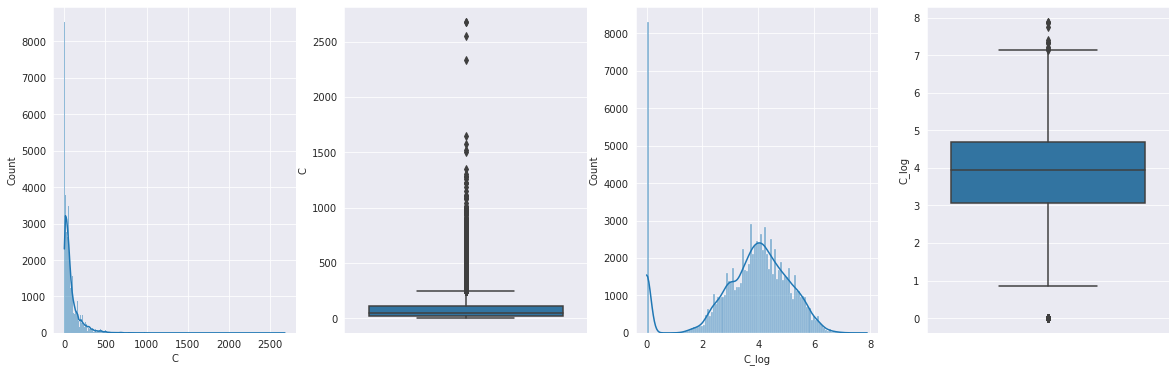

In [ ]:
plot_univariate_numeric(data, 'C', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'C')

Count: 89734
Distinct: 11051
Distinct(%): 12.315287404996992%
Minimum: 0.0
Maximum: 2682.42
Mean: 85.80126585240824
Median: 50.02
Interquartile range: 88.36000000000001

Левая граница выброса: 0.0
Правая граница выброса: 241.47000000000003
Кол-во выбросов: 6950
Кол-во выбросов(%): 7.745113334967793

после логарифмирования:
Левая граница выброса: 0.6284929516165039
Правая граница выброса: 7.142654308375334
Кол-во выбросов: 8305
Кол-во выбросов(%): 9.255131834087415


In [ ]:
data['C'] = np.log(data['C'] + 1)

- после взятия логарифма распределение приняло очень интересную форму: достаточно большая часть объектов сконцентрировалась около нуля, а все остальные приняли форму нормального распределения. Можно попробовать как-то это использовать, например, добавить новый бинарный признак (в одну группу попадут объекты == 0, а в другую - все остальные) и посмотреть, есть ли какая-то зависимость с таргетом; либо 0 может быть индикатором пропущенного значения

In [ ]:
data['C_is_0'] = (data['C'] == 0).astype(int).astype(object)
cat_cols.append('C_is_0')

**D:**

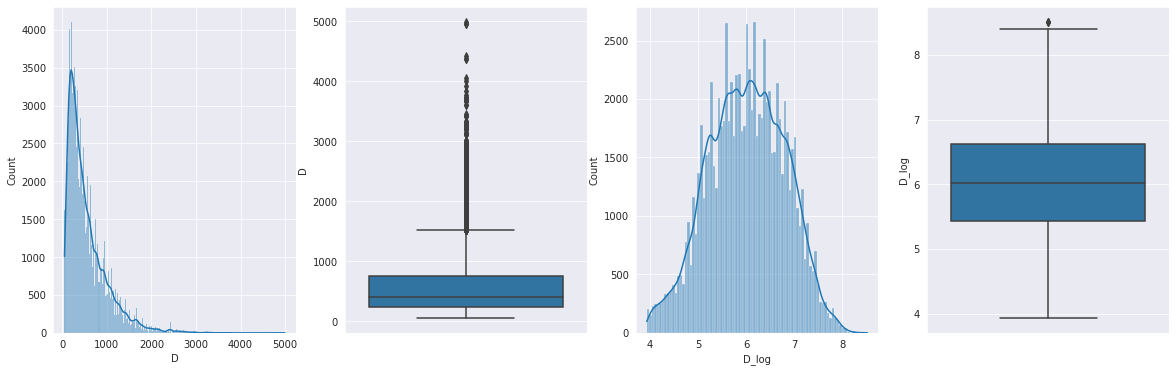

In [ ]:
plot_univariate_numeric(data, 'D', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'D')

Count: 89734
Distinct: 14941
Distinct(%): 16.65032206298616%
Minimum: 49.98
Maximum: 4999.0
Mean: 548.5079541756749
Median: 408.735
Interquartile range: 519.6800000000001

Левая граница выброса: 49.98
Правая граница выброса: 1526.23
Кол-во выбросов: 3558
Кол-во выбросов(%): 3.9650522655849514

после логарифмирования:
Левая граница выброса: 3.9314333989479695
Правая граница выброса: 8.398322206791999
Кол-во выбросов: 3
Кол-во выбросов(%): 0.003343214389194731


In [ ]:
data['D'] = np.log(data['D'] + 1)

- распределение скошено вправо - взяли логарифм
- выбросов всего 3, можно удалить

**E:**

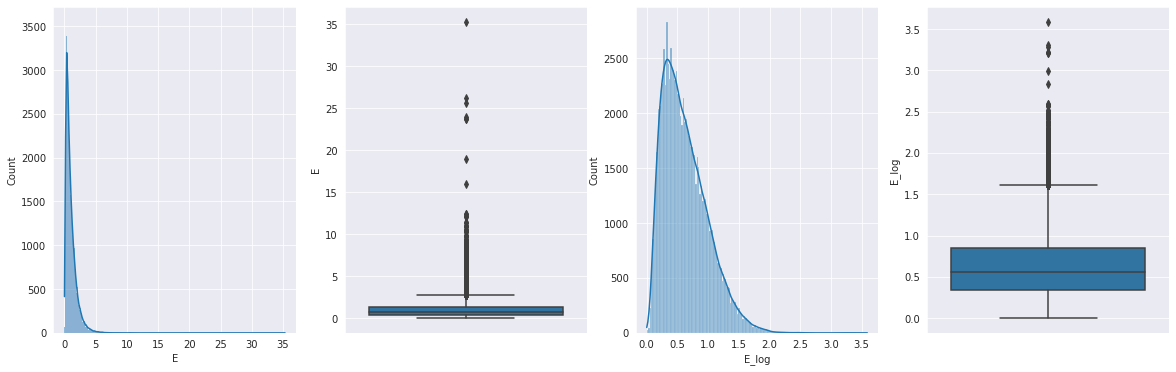

In [ ]:
plot_univariate_numeric(data, 'E', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'E')

Count: 89734
Distinct: 49962
Distinct(%): 55.67789243764906%
Minimum: 1.599e-05
Maximum: 35.337
Mean: 1.0114545339360597
Median: 0.7494033333333333
Interquartile range: 0.9273833333333332

Левая граница выброса: 1.599e-05
Правая граница выброса: 2.7244416666666664
Кол-во выбросов: 4343
Кол-во выбросов(%): 4.839860030757572

после логарифмирования:
Левая граница выброса: 1.5989872161389532e-05
Правая граница выброса: 1.6071749559952655
Кол-во выбросов: 1183
Кол-во выбросов(%): 1.3183408741391223


In [ ]:
data['E'] = np.log(data['E'] + 1)

- распределение скошено вправо - взяли логарифм
- выбросов немного, но пока оставим их и построим модель, а потом вернемся к этому при необходимости

**F:**

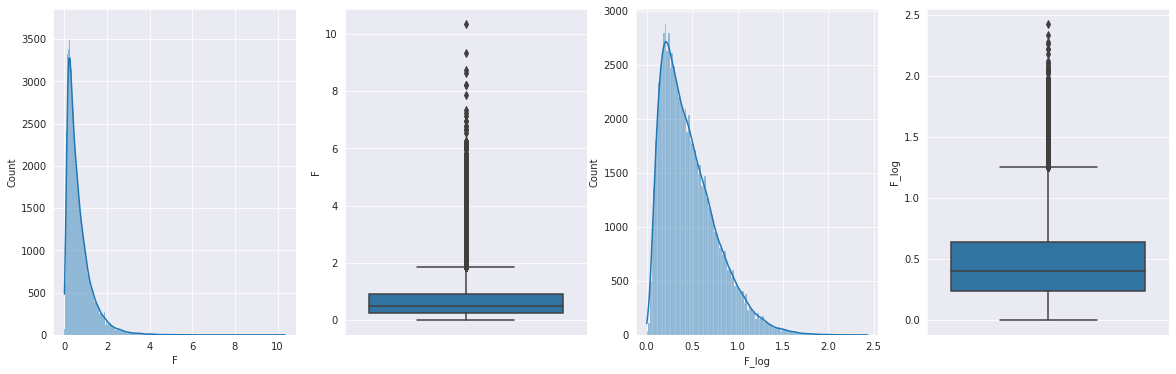

In [ ]:
plot_univariate_numeric(data, 'F', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'F')

Count: 89734
Distinct: 59471
Distinct(%): 66.27476764659995%
Minimum: 1.1844444444444445e-05
Maximum: 10.352991452991452
Mean: 0.6836395281670219
Median: 0.49938666666666665
Interquartile range: 0.635485

Левая граница выброса: 1.1844444444444445e-05
Правая граница выброса: 1.8524874999999998
Кол-во выбросов: 4624
Кол-во выбросов(%): 5.153007778545479

после логарифмирования:
Левая граница выброса: 1.1844374299475072e-05
Правая граница выброса: 1.252505931233208
Кол-во выбросов: 1786
Кол-во выбросов(%): 1.9903269663672631


In [ ]:
data['F'] = np.log(data['F'] + 1)

- распределение скошено вправо - взяли логарифм
- выбросов немного, но пока оставим их и построим модель, а потом вернемся к этому при необходимости

**G:**

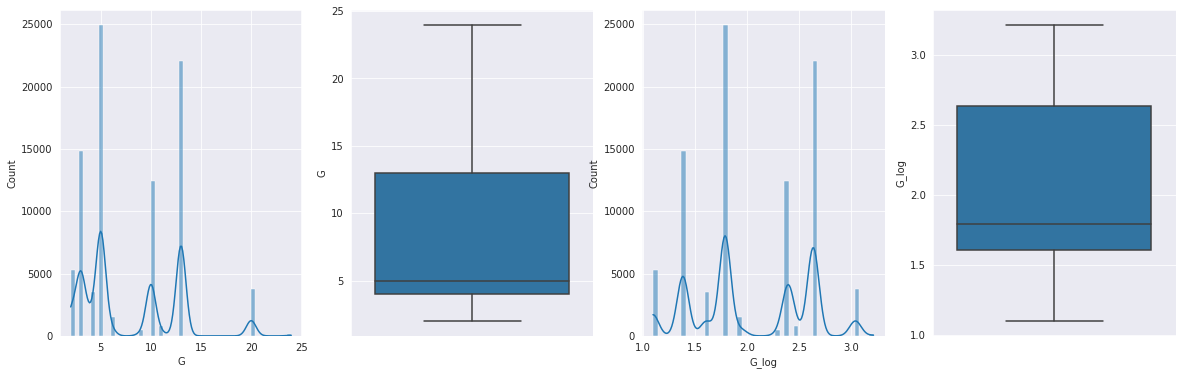

In [ ]:
plot_univariate_numeric(data, 'G', figsize=(20, 6))

- будем рассматривать этот признак как категориальный

In [ ]:
data[['G']] = data[['G']].astype(object)

**H:**

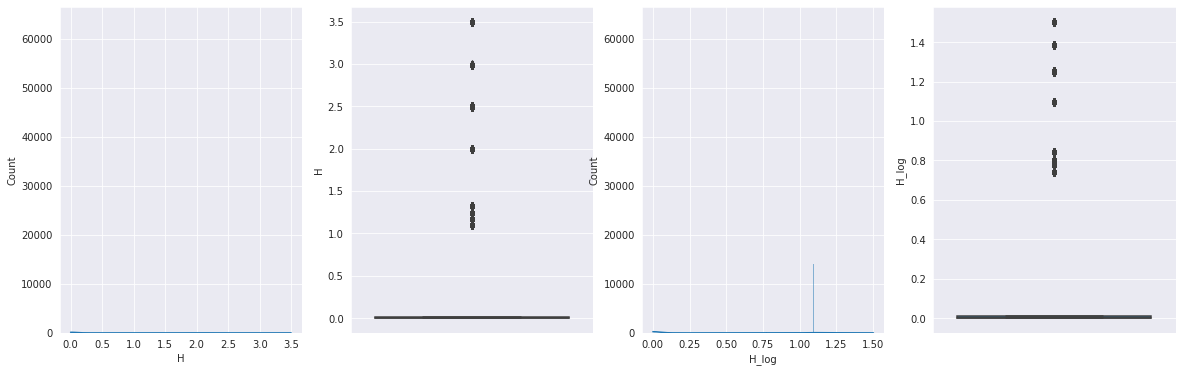

In [ ]:
plot_univariate_numeric(data, 'H', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'H')

Count: 89734
Distinct: 13
Distinct(%): 0.014487262353177167%
Minimum: 0.0
Maximum: 3.5
Mean: 0.5102740878596741
Median: 0.0
Interquartile range: 0.01

Левая граница выброса: 0.0
Правая граница выброса: 0.025
Кол-во выбросов: 21273
Кол-во выбросов(%): 23.70673323377984

после логарифмирования:
Левая граница выброса: 0.0
Правая граница выброса: 0.02487582713292023
Кол-во выбросов: 21273
Кол-во выбросов(%): 23.70673323377984


- будем рассматривать этот признак как категориальный
- можно попробовать вывести новый бинарный признак (значение текущего признака == 0 или нет); либо 0 может быть индикатором пропущенного значения

In [ ]:
data[['H']] = data[['H']].astype(object)
data['H_is_0'] = (data['H'] == 0).astype(int).astype(object)

**J**:

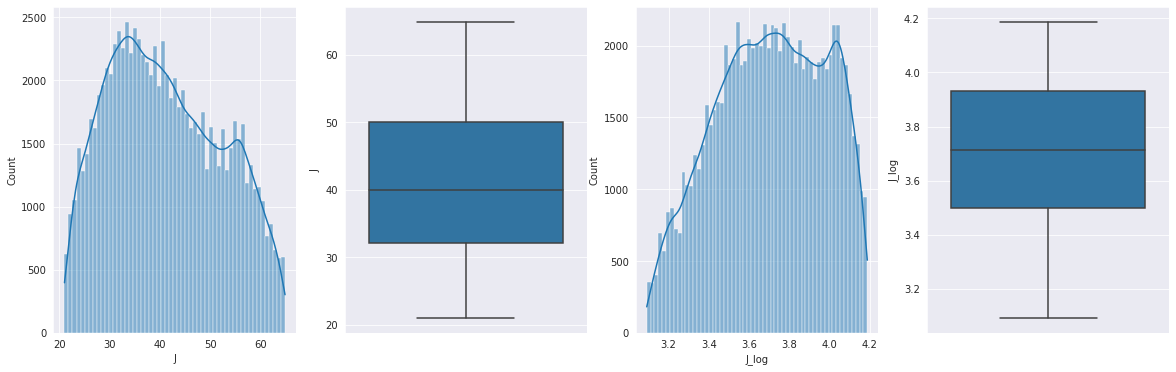

In [ ]:
plot_univariate_numeric(data, 'J', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'J')

Count: 89734
Distinct: 528
Distinct(%): 0.5884057324982727%
Minimum: 21.0
Maximum: 64.91666666666667
Mean: 41.14077811457567
Median: 40.0
Interquartile range: 17.916666666666664

Левая граница выброса: 21.0
Правая граница выброса: 64.91666666666667
Кол-во выбросов: 0
Кол-во выбросов(%): 0.0

после логарифмирования:
Левая граница выброса: 3.091042453358316
Правая граница выброса: 4.1883913179796535
Кол-во выбросов: 0
Кол-во выбросов(%): 0.0


- признак - возраст
- распредление слегка скошено вправо, нормальное, логарифм брать не будем
- выбросов нет

**L:**

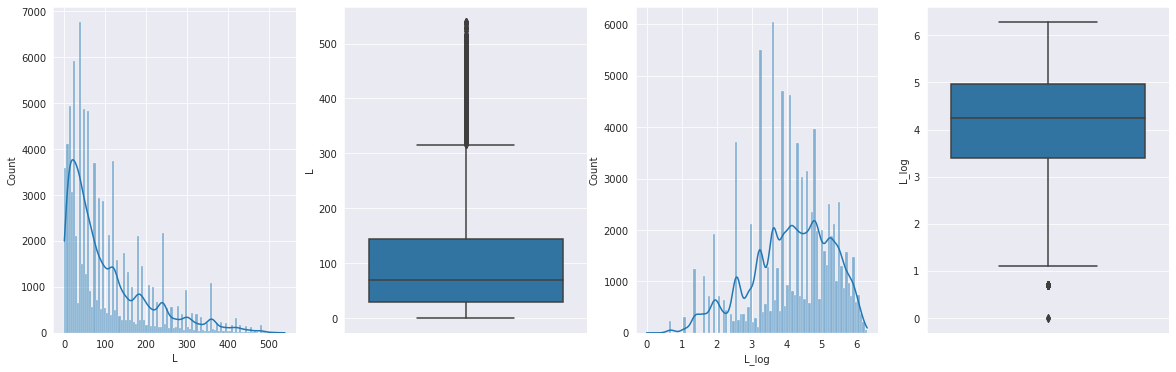

In [ ]:
plot_univariate_numeric(data, 'L', figsize=(20, 6))

In [ ]:
print_numeric_stats(data, 'L')

Count: 89734
Distinct: 511
Distinct(%): 0.5694608509595025%
Minimum: 0
Maximum: 540
Mean: 103.71909198297189
Median: 69.0
Interquartile range: 115.0

Левая граница выброса: 0
Правая граница выброса: 316.5
Кол-во выбросов: 4665
Кол-во выбросов(%): 5.198698375197807

после логарифмирования:
Левая граница выброса: 1.0378928405245271
Правая граница выброса: 6.293419278846481
Кол-во выбросов: 226
Кол-во выбросов(%): 0.25185548398600305


In [ ]:
data['L'] = np.log(data['L'] + 1)

- распределение скошено вправо - взяли логарифм
- выбросов немного, можно удалить

### 1.2 Categorical variables

In [ ]:
cat_cols = data.select_dtypes(include='object').columns.tolist()
print(cat_cols)
print(f"Number of categorical columns: {len(cat_cols)}")

['G', 'H', 'I', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'MARKER', 'C_is_0', 'H_is_0']
Number of categorical columns: 19


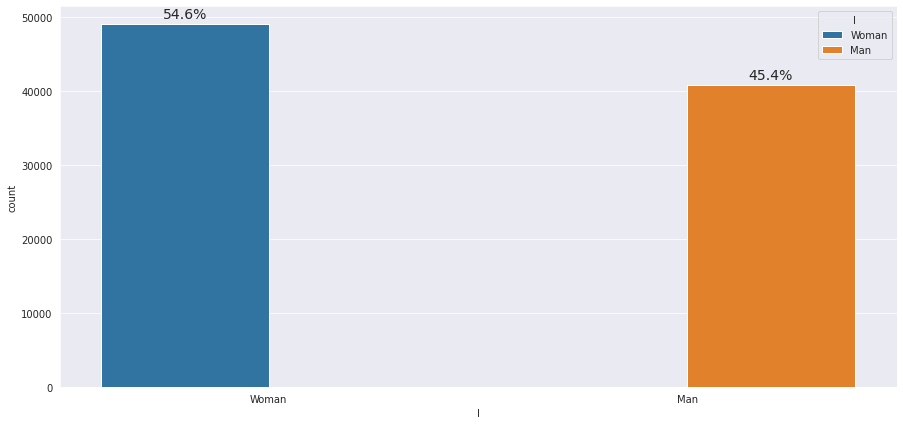

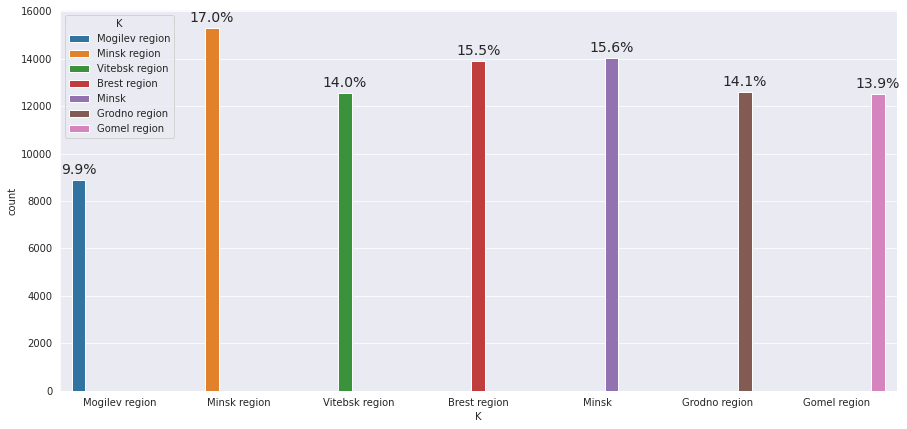

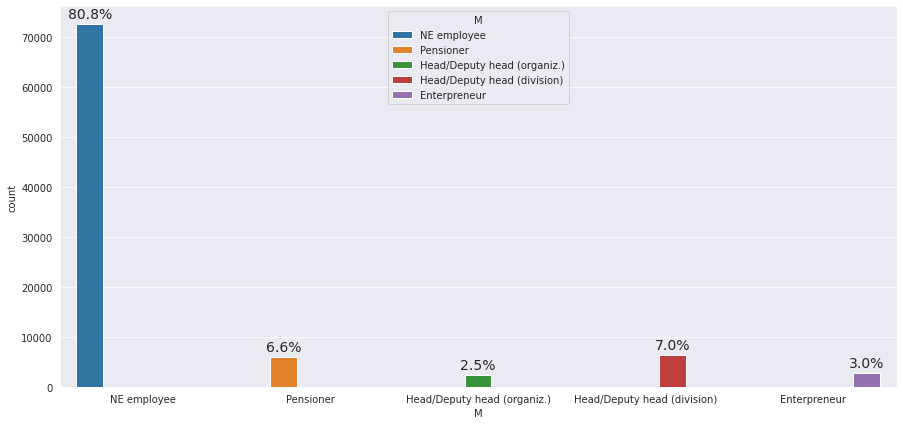

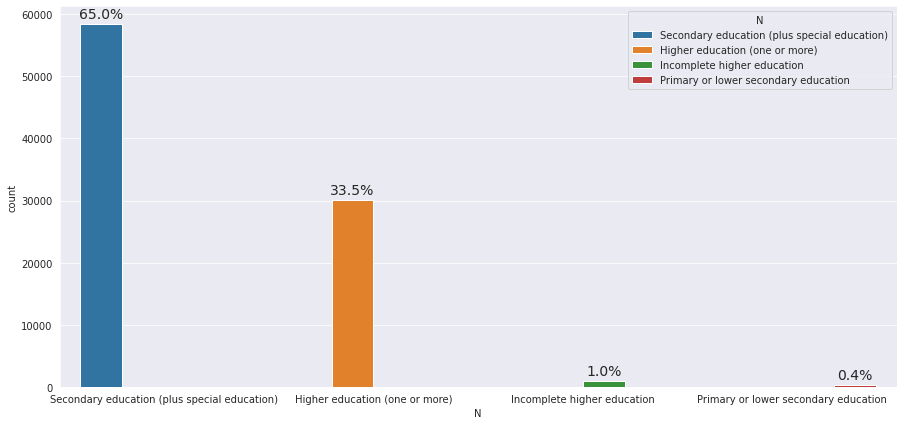

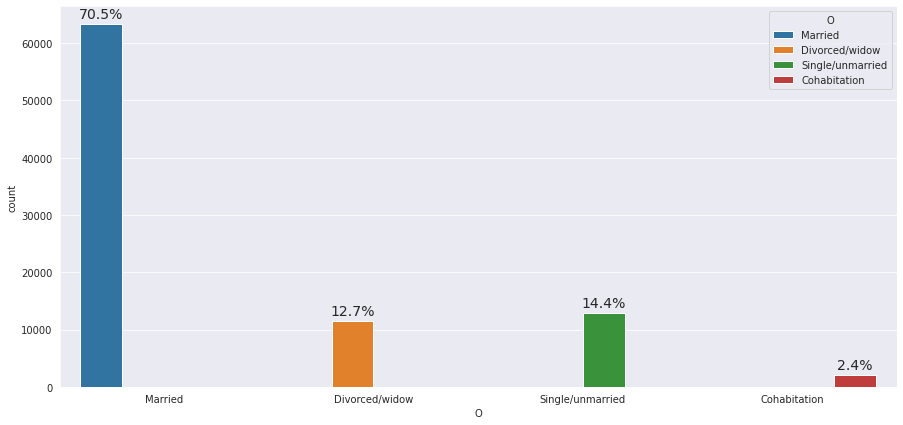

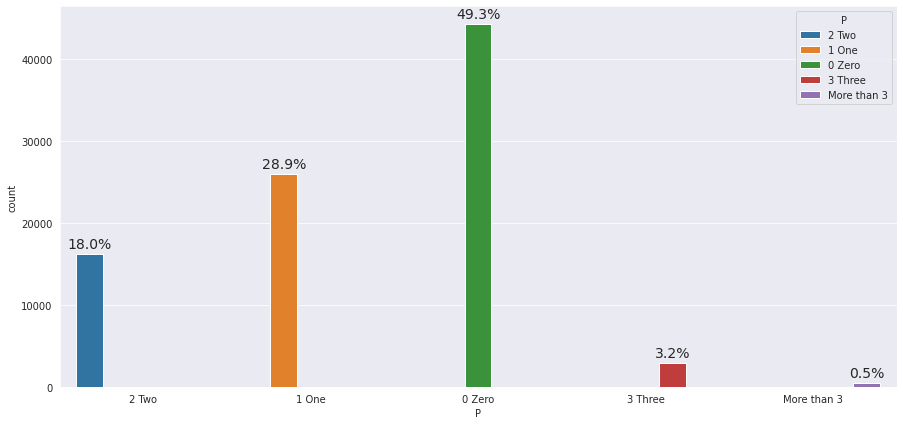

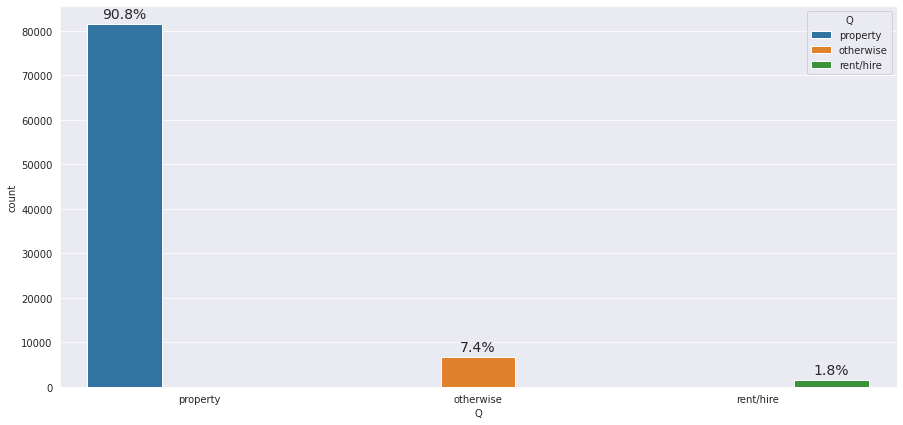

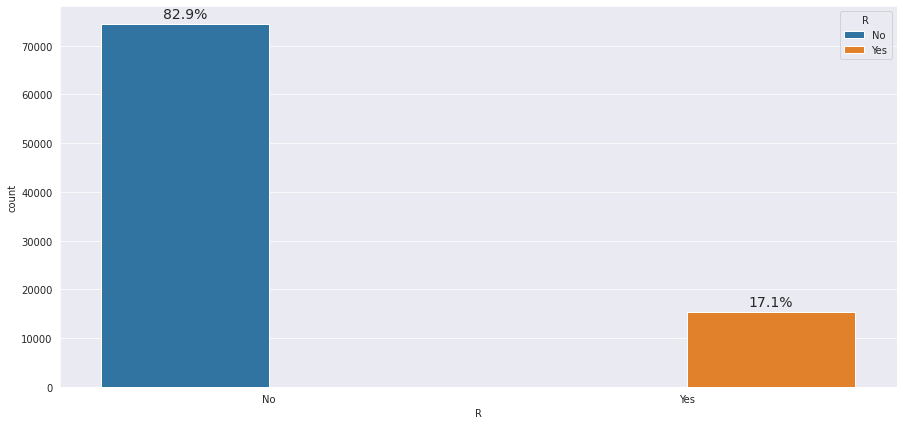

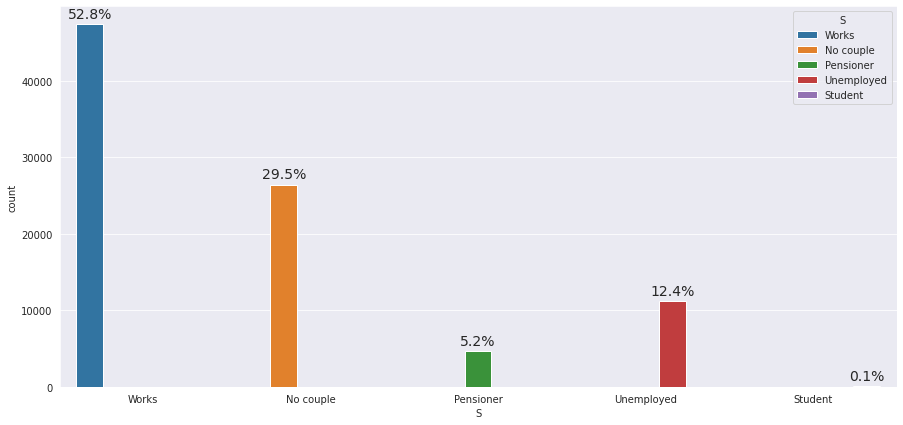

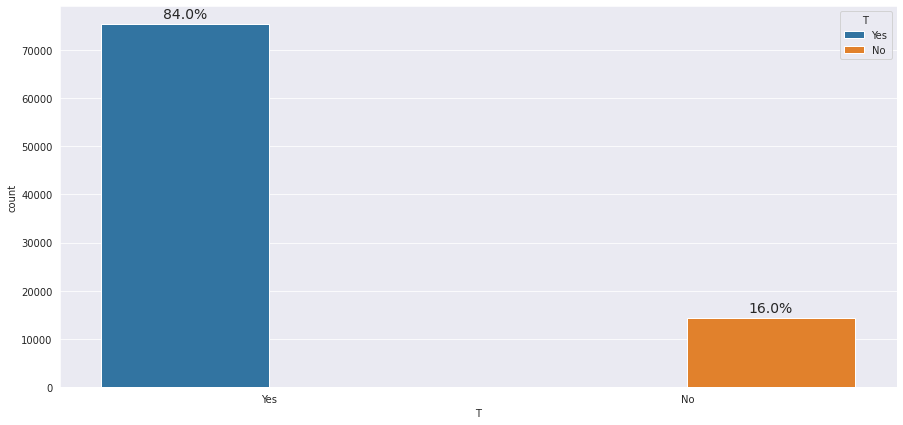

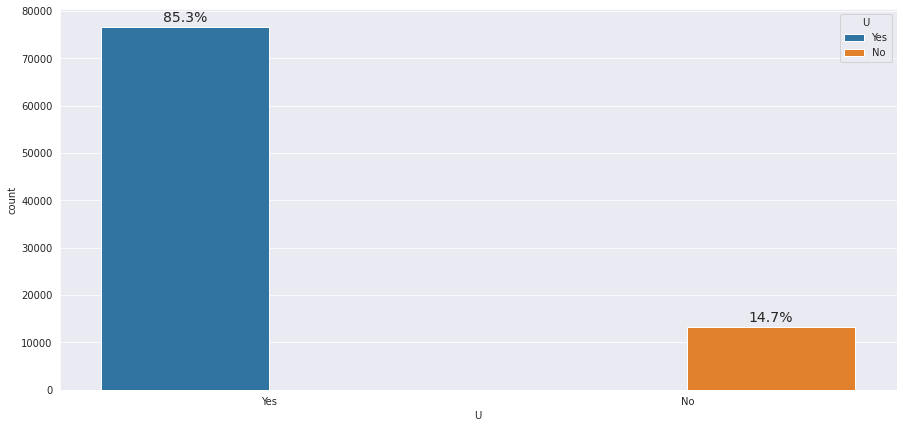

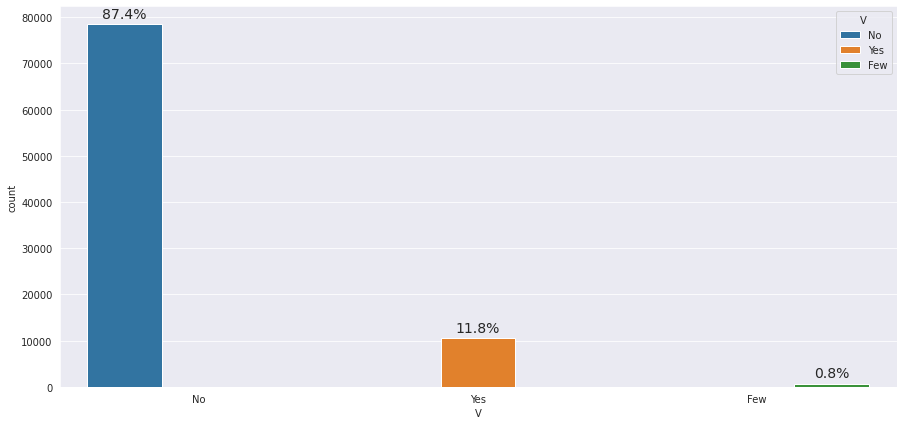

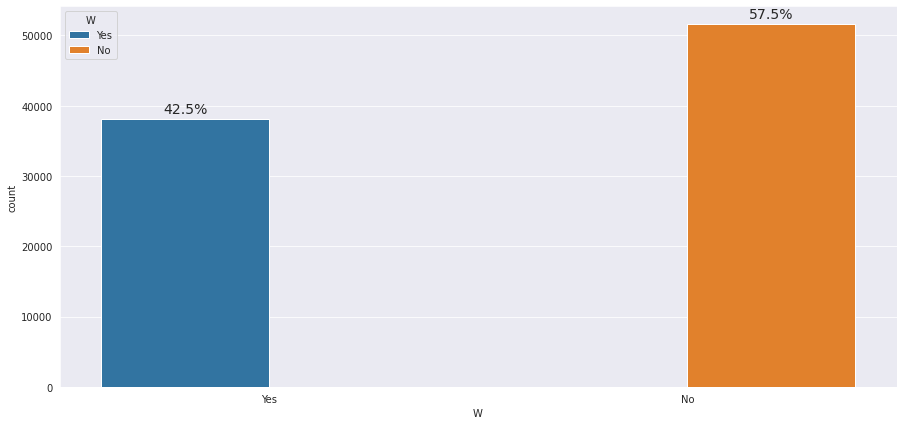

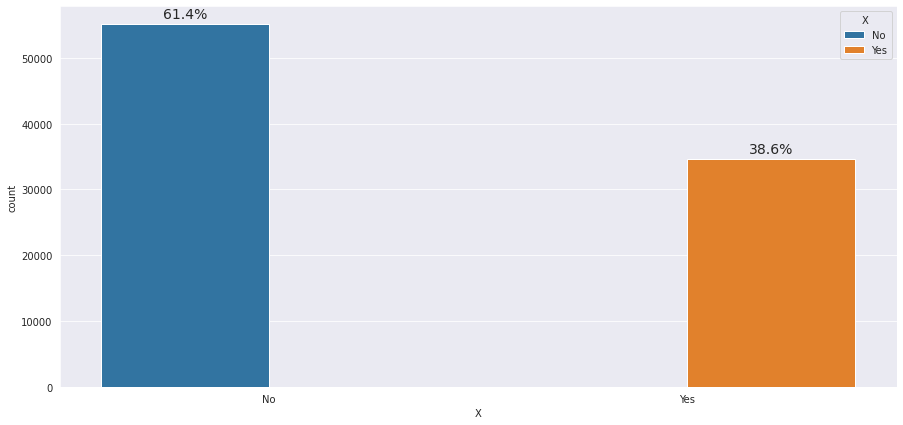

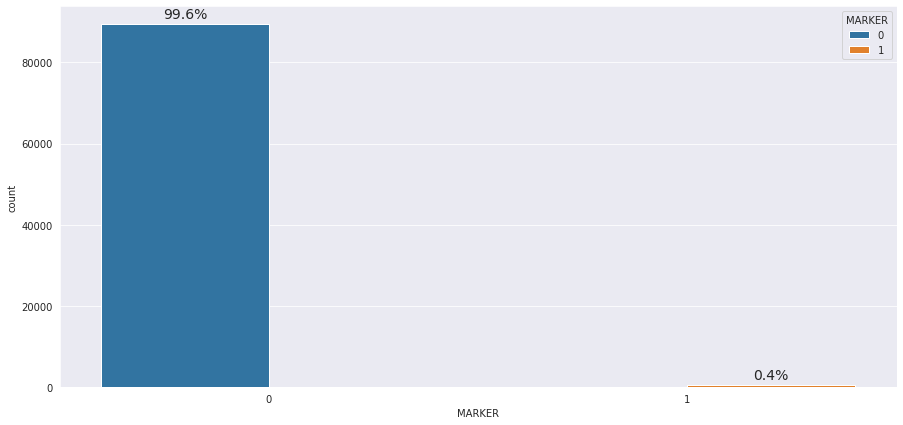

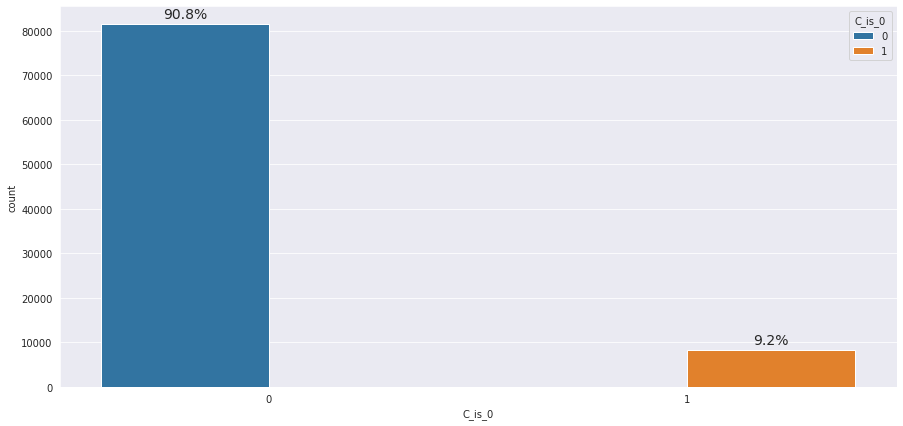

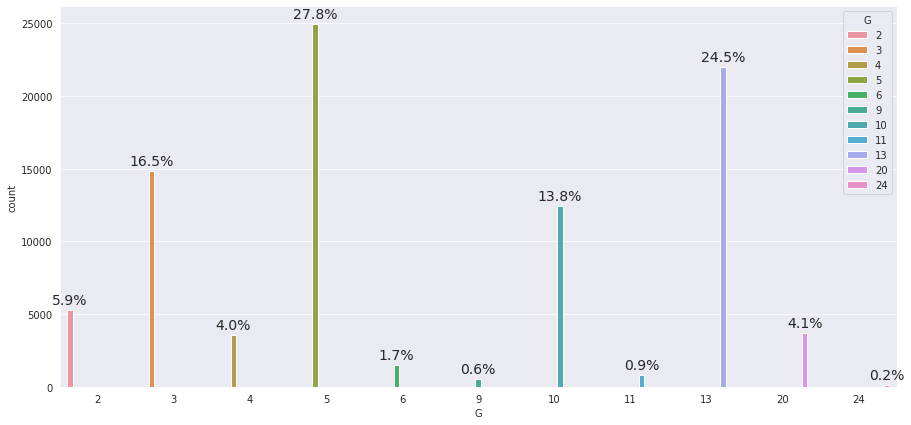

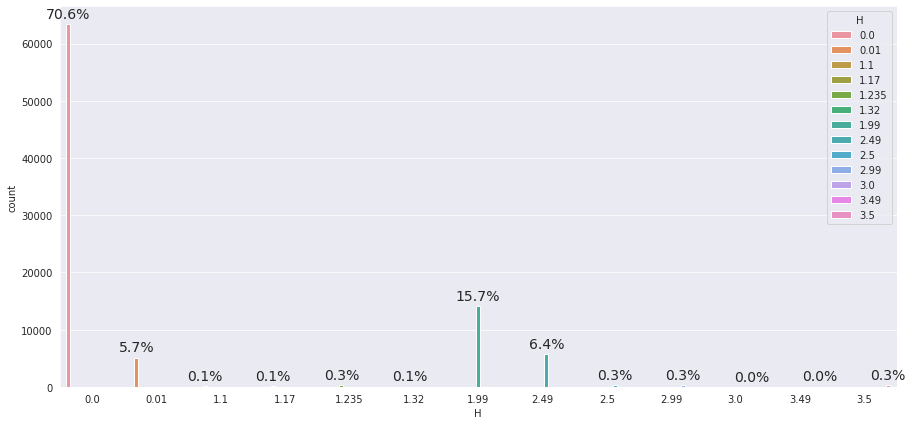

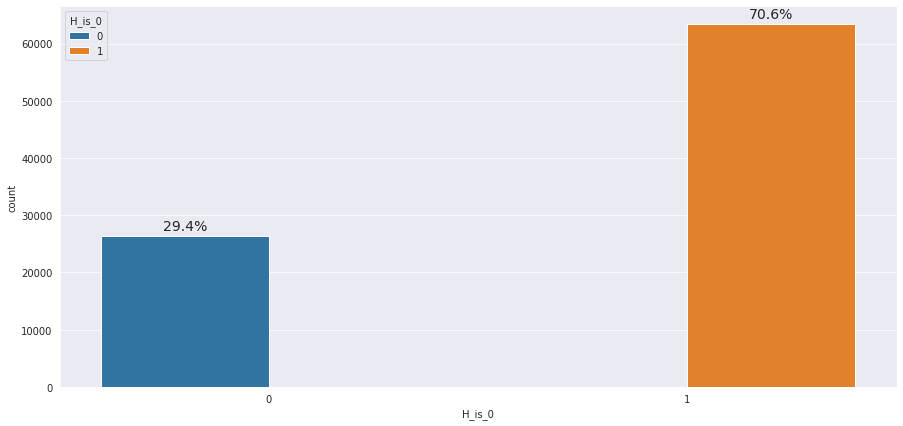

In [ ]:
for col_name in cat_cols:
  plot_univariate_categoric(data, col_name, figsize=(15, 7))

- **I** - пол, в датасете примерно равное кол-во мужчин и женщин
- **K** - область, клиенты распределены по областям относительно равномерно
- **M** - что-то вроде рабочего статуса, судя по значениям признака (Head, Enterpreneur, etc.) NE employee может быть наёмным рабочим
- **S** вызывает вопросы, похоже на occupation, но что может значить значение "no couple" в данном контексте? К тому же, кол-во пенсионеров в признаке **S** отличается от кол-ва пенсионеров в признаке **M** и как согласуются "unemployed" и "student" со значениями признака **M**, в котором все кроме категории "pensioner" вроде работают?
- **N** - уровень образования
- **O** - семейное положение
- **P** - кол-во детей в семье? Значения колонок можно очистить и оставить только цифры
- **Q** - наличие квартиры?
- оставшиеся бинарыне/тернарные признаки пока непонятно, как можно интерпретирововать; думаю, что какой-то из них может быть ответом на вопрос "привлекались ли к уголовной/администартивной ответственности"

In [ ]:
data.rename(columns={'J': 'age', 'I': 'sex', 'K': 'region', 'N': 'education', 'O': 'marital_status', 'P': 'n_children', 'Q': 'housing'})
num_cols = data.select_dtypes(include='number').columns.tolist()
cat_cols = data.select_dtypes(include='object').columns.tolist()

## Initial hypotheses / investigation themes to explore

- изучить распределение пола в зависимости от таргета (мужчины чаще берут кредит? женщинам выдают реже, потому что они могут находиться в декретном отпуске или только выйти из него?), изучить взаимодействие различных переменных (пол/семейное положение/кол-во детей/наличие собственности) с таргетом
- изучить распределение областей в зависимости от таргета
- изучить распределение рабочего статуса (**M**) в зависимости от таргета (head'ам чаще выдают кредит?), изучить взаимодействие этой переменной с переменной **S**, попробовать разобраться, как они соотносятся
- изучить распределение семейного положения в зависимости от таргета ("хорошие" заёмщики замужние/женатые, т.к. им проще выплатить кредит?)
- изучить распределение кол-ва детей в зависимости от таргета ("хорошие" имеют меньше (например, меньше финансовых обязательств, поэтому проще выплатить кредит) или больше (например, могут больше нуждаться в кредите) детей?)
- изучить распределение возраста в зависимости от таргета (возраст "хороших" заёмщиков выше, чем возраст "плохих"?)
- изучить распределение уровня образования в зависимости от таргета (уровень образования "хороших" заёмщиков выше?)

## 2. Exploring the relationship between each variable and the target

### 2.1 Numeric x Target

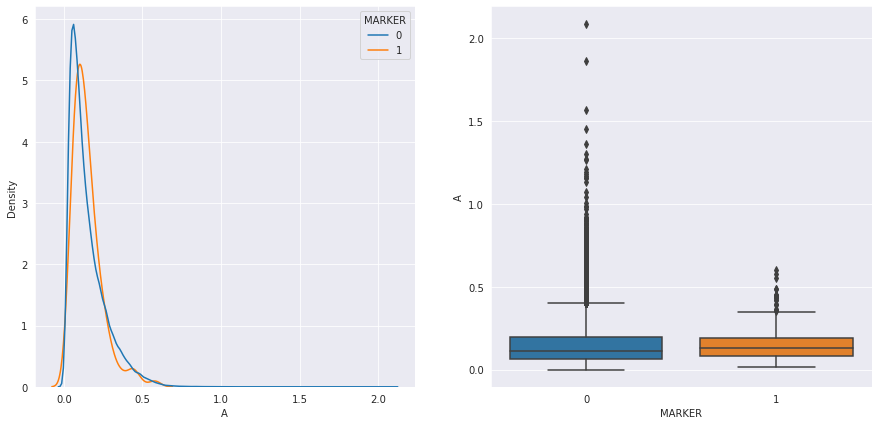

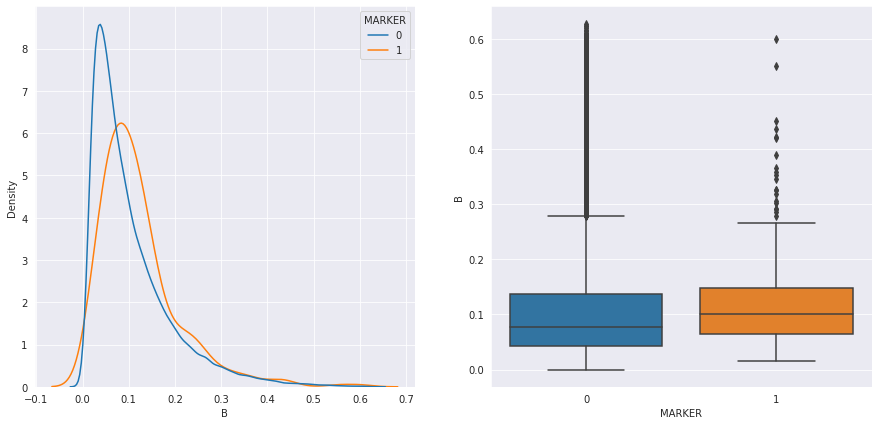

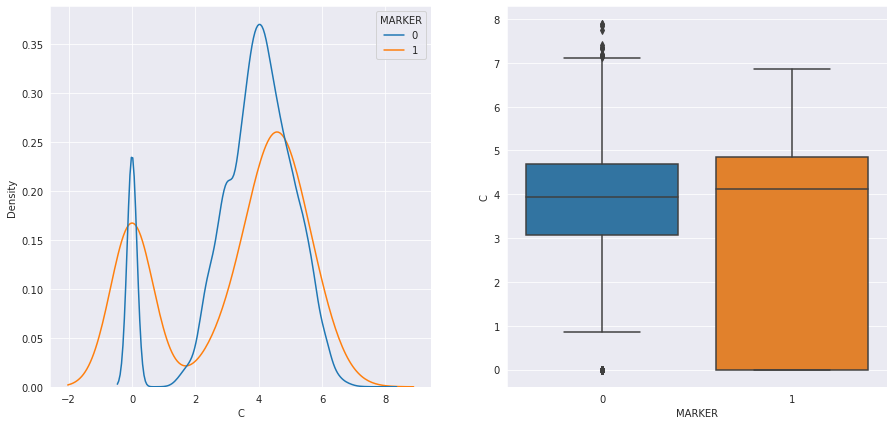

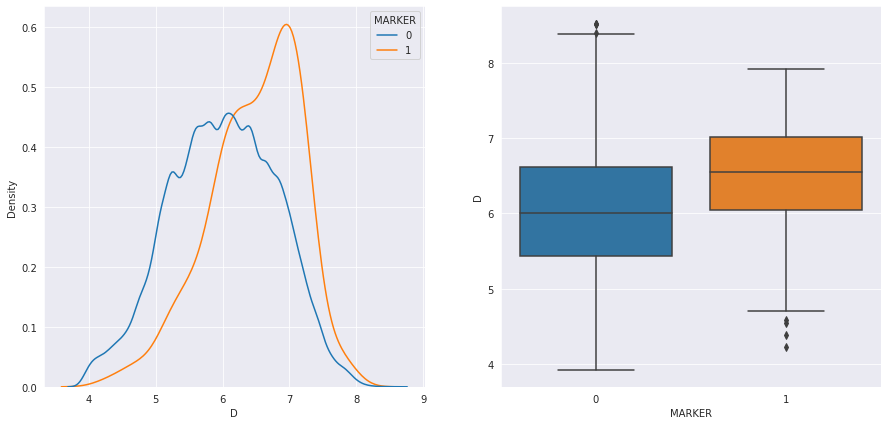

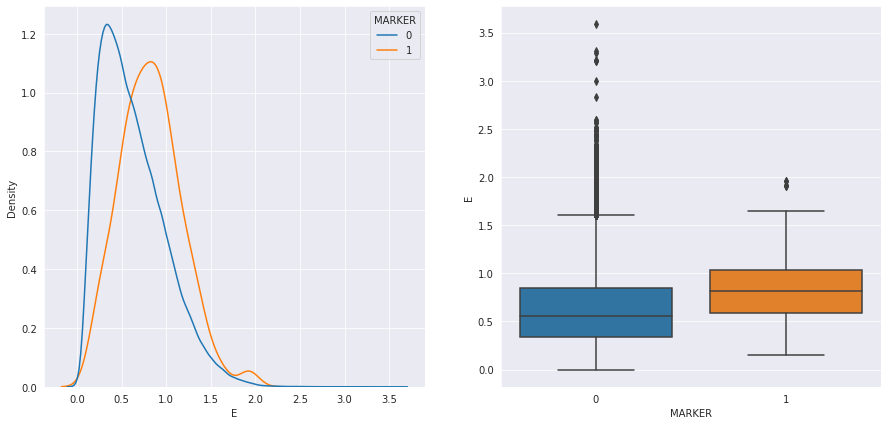

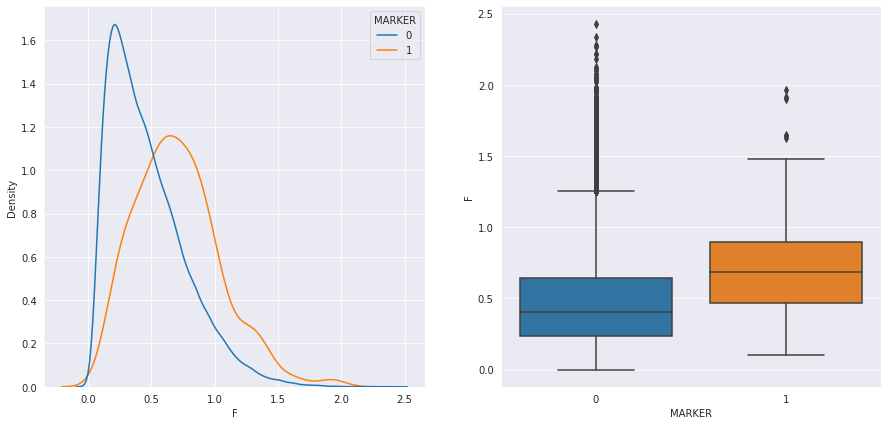

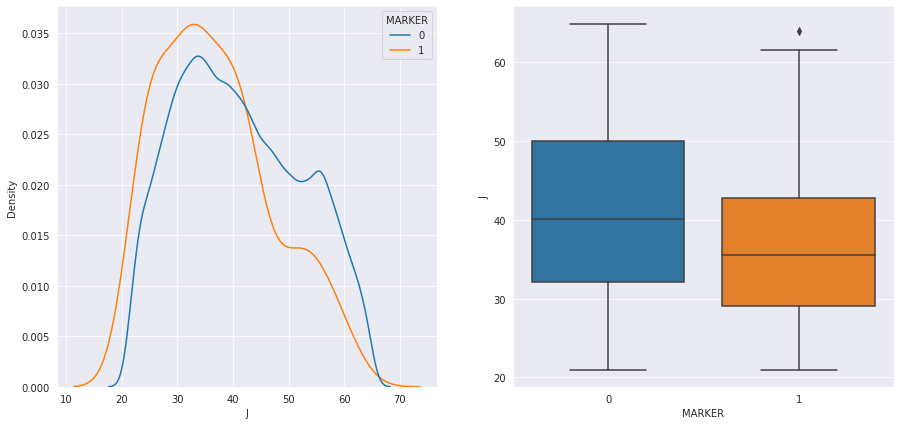

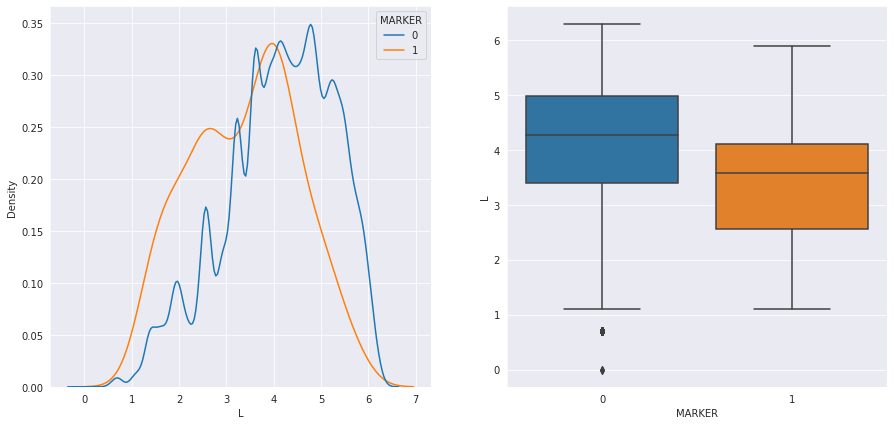

In [ ]:
for col_name in num_cols:
  plot_bivariate_numeric(data, col_name, figsize=(15, 7))

- заметных различий по переменной **A** в разрезе target'a нет
- 

## 3. Assessing interactions between variables